In [142]:
%matplotlib inline
import numpy as np # imports a fast numerical programming library
import scipy as sp # imports stats functions, amongst other things
import matplotlib as mpl # this actually imports matplotlib
import matplotlib.cm as cm # allows us easy access to colormaps
import matplotlib.pyplot as plt # sets up plotting under plt
import pandas as pd # lets us handle data as dataframes
from scipy.optimize import curve_fit
#import pickle

# sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import seaborn as sns # sets up styles and gives us more plotting options

In [5]:
#data = pd.read_csv('./data/Video_Games_Sales_as_at_22_Dec_2016.csv')
data = pd.read_csv('./data/games_sales_clean.csv')
data.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,Wii Sports,Wii,2006,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53
1,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52
3,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


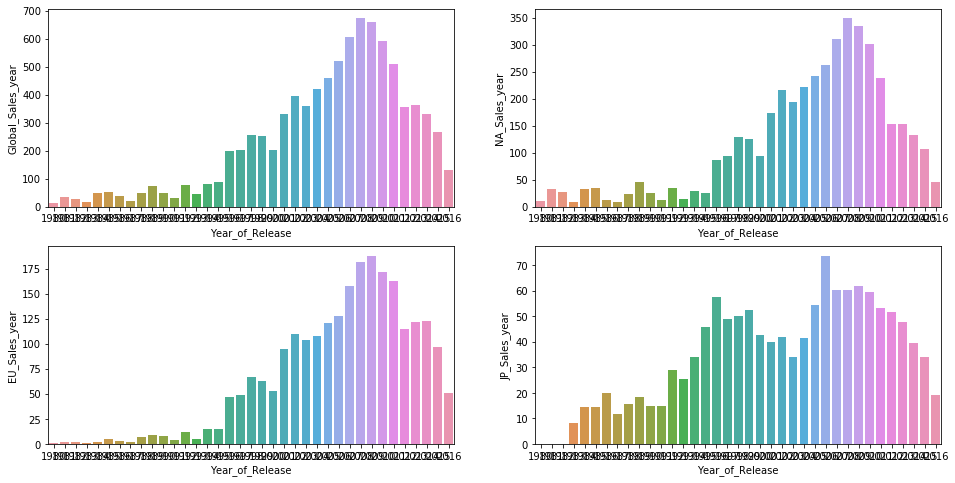

In [6]:
# sales figures over the years - Inflation not taken into account
sales_data = data.groupby(['Year_of_Release'])['Global_Sales'].agg(Global_Sales_year='sum')
NA_sales_data = data.groupby(['Year_of_Release'])['NA_Sales'].agg(NA_Sales_year='sum')
EU_sales_data = data.groupby(['Year_of_Release'])['EU_Sales'].agg(EU_Sales_year='sum')
JP_sales_data = data.groupby(['Year_of_Release'])['JP_Sales'].agg(JP_Sales_year='sum')

plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.barplot(x=sales_data.index, y=sales_data['Global_Sales_year'])
plt.subplot(2,2,2)
sns.barplot(x=NA_sales_data.index, y=NA_sales_data['NA_Sales_year'])
plt.subplot(2,2,3)
sns.barplot(x=EU_sales_data.index, y=EU_sales_data['EU_Sales_year'])
plt.subplot(2,2,4)
sns.barplot(x=JP_sales_data.index, y=JP_sales_data['JP_Sales_year'])

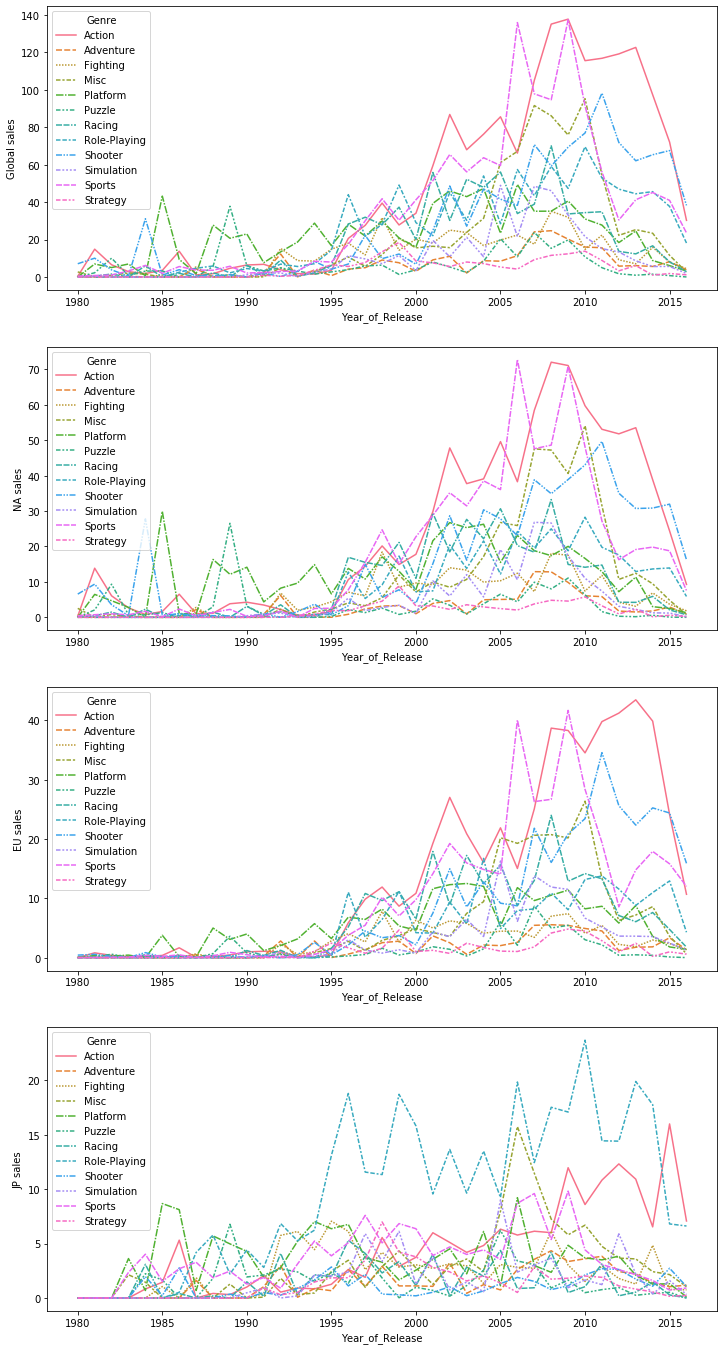

In [7]:
# sales figures per year and genre (Global, NA, EU and JP)
genre_data = data.groupby(['Year_of_Release','Genre'])['Global_Sales'].agg(Global_Sales_year='sum')
NA_genre_data = data.groupby(['Year_of_Release','Genre'])['NA_Sales'].agg(NA_Sales_year='sum')
EU_genre_data = data.groupby(['Year_of_Release','Genre'])['EU_Sales'].agg(EU_Sales_year='sum')
JP_genre_data = data.groupby(['Year_of_Release','Genre'])['JP_Sales'].agg(JP_Sales_year='sum')

#reshapes the table so the second index becomes the columns instead
genre_data = genre_data.reset_index().pivot(columns='Genre',index='Year_of_Release',values='Global_Sales_year').fillna(0)
NA_genre_data = NA_genre_data.reset_index().pivot(columns='Genre',index='Year_of_Release',values='NA_Sales_year').fillna(0)
EU_genre_data = EU_genre_data.reset_index().pivot(columns='Genre',index='Year_of_Release',values='EU_Sales_year').fillna(0)
JP_genre_data = JP_genre_data.reset_index().pivot(columns='Genre',index='Year_of_Release',values='JP_Sales_year').fillna(0)

plt.figure(figsize=(12,6*4))
plt.subplot(4,1,1)
sns.lineplot(data=genre_data)
plt.ylabel('Global sales')
plt.subplot(4,1,2)
sns.lineplot(data=NA_genre_data)
plt.ylabel('NA sales')
plt.subplot(4,1,3)
sns.lineplot(data=EU_genre_data)
plt.ylabel('EU sales')
plt.subplot(4,1,4)
sns.lineplot(data=JP_genre_data)
plt.ylabel('JP sales')
plt.show()

To better compare the data over the years we take a look at the realtive sales, i.e. the market share of every genre on the total sales per year.

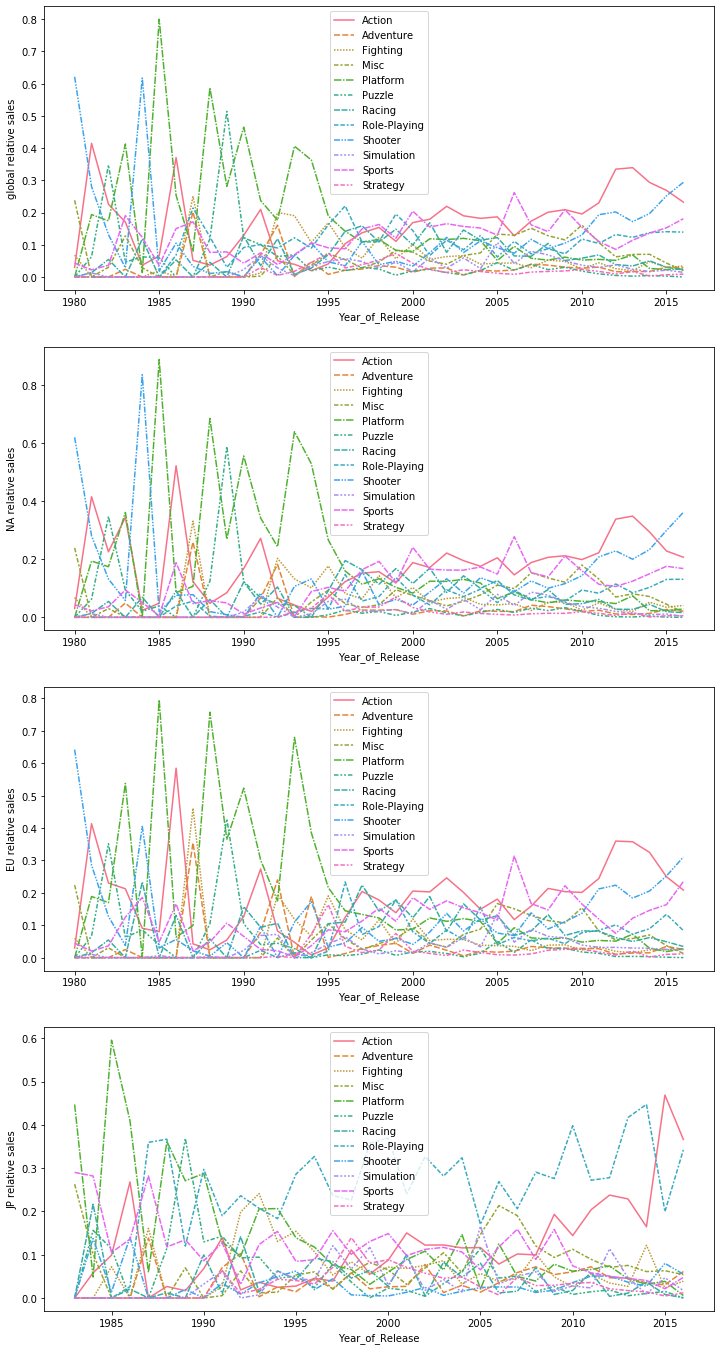

In [8]:
# relative sales figures per genre and year (Global, NA, EU, JP)
genre_rel = pd.concat([genre_data, sales_data], axis=1,sort=False)
genre_rel = genre_rel.div(genre_rel['Global_Sales_year'], axis=0).drop(columns='Global_Sales_year')
NA_genre_rel = pd.concat([NA_genre_data, NA_sales_data], axis=1,sort=False)
NA_genre_rel = NA_genre_rel.div(NA_genre_rel['NA_Sales_year'], axis=0).drop(columns='NA_Sales_year')
EU_genre_rel = pd.concat([EU_genre_data, EU_sales_data], axis=1,sort=False)
EU_genre_rel = EU_genre_rel.div(EU_genre_rel['EU_Sales_year'], axis=0).drop(columns='EU_Sales_year')
JP_genre_rel = pd.concat([JP_genre_data, JP_sales_data], axis=1,sort=False)
JP_genre_rel = JP_genre_rel.div(JP_genre_rel['JP_Sales_year'], axis=0).drop(columns='JP_Sales_year')

# plot the results 
plt.figure(figsize=(12,6*4))

plt.subplot(4,1,1)
sns.lineplot(data=genre_rel)
plt.ylabel('global relative sales')
plt.subplot(4,1,2)
sns.lineplot(data=NA_genre_rel)
plt.ylabel('NA relative sales')
plt.subplot(4,1,3)
sns.lineplot(data=EU_genre_rel)
plt.ylabel('EU relative sales')
plt.subplot(4,1,4)
sns.lineplot(data=JP_genre_rel)
plt.ylabel('JP relative sales')
plt.show()

Obviously the landscape of videogame genres changed drastically in the years '90. For regression and further analysis we limit ourselfs to the more recent years, i.e. the years 2000-2016.

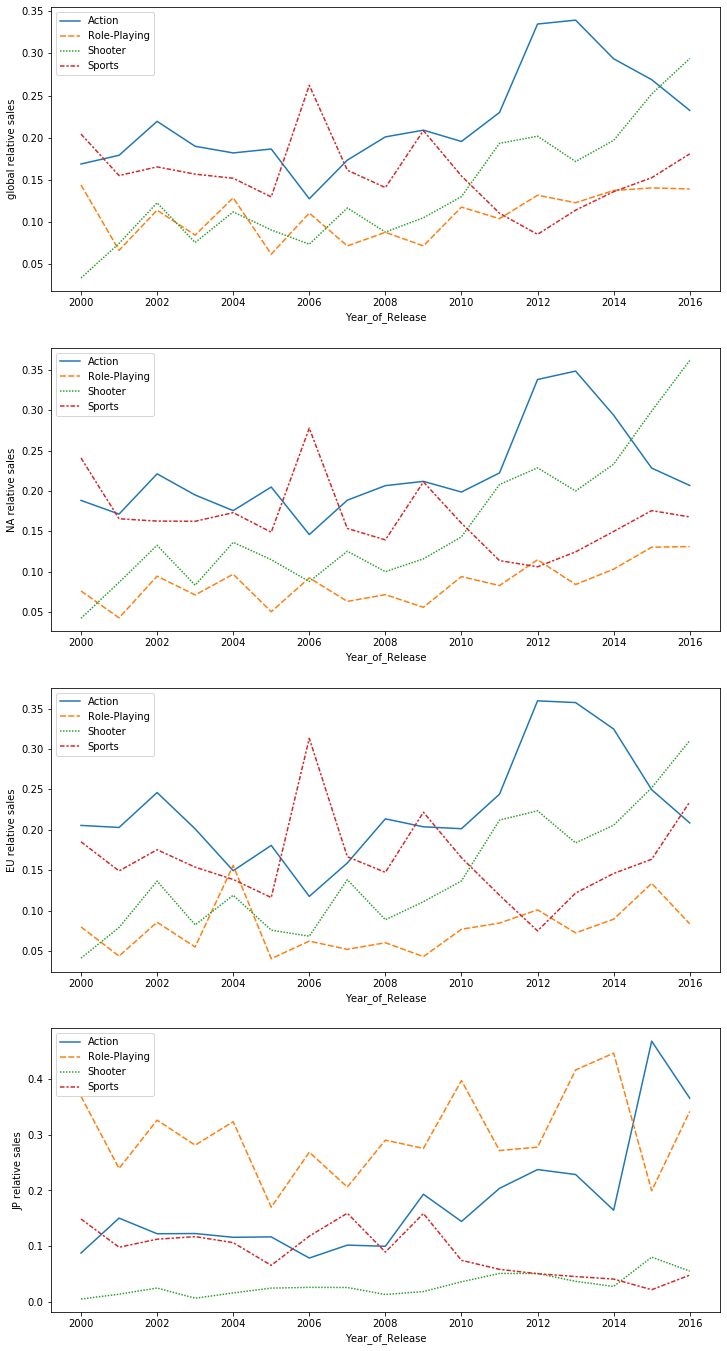

In [16]:
# drop all rows with release date before 2000 (Global, NA, EU, JP)
indizes = genre_rel[genre_rel.index<2000].index
genre_rel.drop(indizes, inplace=True)
indizes = NA_genre_rel[NA_genre_rel.index<2000].index
NA_genre_rel.drop(indizes, inplace=True)
indizes = EU_genre_rel[EU_genre_rel.index<2000].index
EU_genre_rel.drop(indizes, inplace=True)
indizes = JP_genre_rel[JP_genre_rel.index<2000].index
JP_genre_rel.drop(indizes, inplace=True)

# plot the results
plt.figure(figsize=(12,6*4))

plt.subplot(4,1,1)
sns.lineplot(data=genre_rel)
plt.ylabel('global relative sales')
plt.legend(loc=2)
plt.subplot(4,1,2)
sns.lineplot(data=NA_genre_rel)
plt.ylabel('NA relative sales')
plt.legend(loc=2)
plt.subplot(4,1,3)
sns.lineplot(data=EU_genre_rel)
plt.ylabel('EU relative sales')
plt.legend(loc=2)
plt.subplot(4,1,4)
sns.lineplot(data=JP_genre_rel)
plt.ylabel('JP relative sales')
plt.legend(loc=2)
plt.show()

We now have a look at the data in those last 16 years. For the regression we focus only on the top 4 Genres in 2016.

In [17]:
# # Prepare data so the sales are relative to the figures of the whole year
# data_rel = data.merge(sales_data, on=['Year_of_Release'])
# data_rel[['NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales']] = data_rel[['NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales']].div(data_rel['Global_Sales_year'], axis=0)

# # drop all rows with release date before 2000
# indizes = data_rel[data_rel['Year_of_Release']<2000].index
# data_rel.drop(indizes, inplace=True)


# plt.figure(figsize=(16,8))
# plt.ylabel('relative sales')
# plt.xlabel('year of release')
# sns.scatterplot(x=data_rel['Year_of_Release'], y=data_rel['Global_Sales'], hue=data_rel['Genre'])

Wow, there is nothing to see....

In [18]:
#sns.swarmplot(x=data_rel['Genre'],y=data_rel['Global_Sales'])

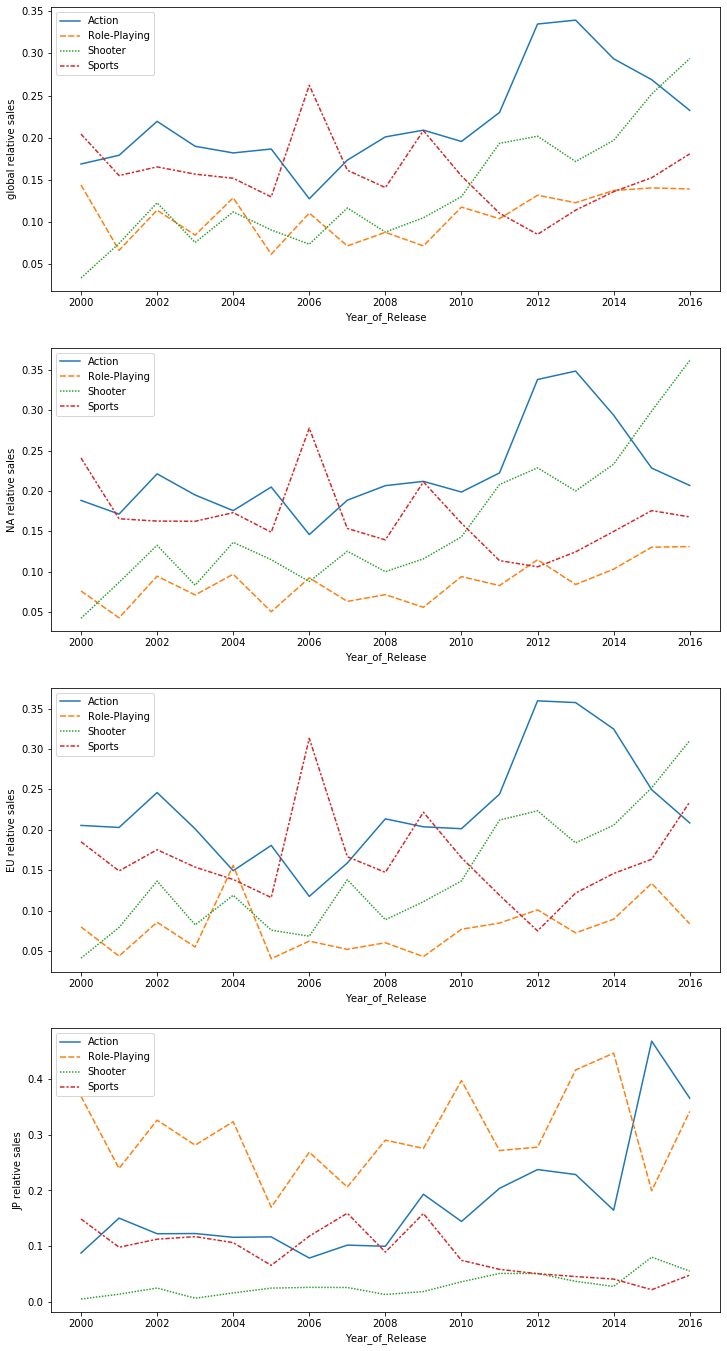

In [19]:
# drop all columns except four most successful genres
genre_rel.drop(genre_rel.columns.difference(['Action','Role-Playing','Shooter','Sports']), 1, inplace=True)
NA_genre_rel.drop(NA_genre_rel.columns.difference(['Action','Role-Playing','Shooter','Sports']), 1, inplace=True)
EU_genre_rel.drop(EU_genre_rel.columns.difference(['Action','Role-Playing','Shooter','Sports']), 1, inplace=True)
JP_genre_rel.drop(JP_genre_rel.columns.difference(['Action','Role-Playing','Shooter','Sports']), 1, inplace=True)

# plot the results
plt.figure(figsize=(12,6*4))

plt.subplot(4,1,1)
sns.lineplot(data=genre_rel)
plt.ylabel('global relative sales')
plt.legend(loc=2)
plt.subplot(4,1,2)
sns.lineplot(data=NA_genre_rel)
plt.ylabel('NA relative sales')
plt.legend(loc=2)
plt.subplot(4,1,3)
sns.lineplot(data=EU_genre_rel)
plt.ylabel('EU relative sales')
plt.legend(loc=2)
plt.subplot(4,1,4)
sns.lineplot(data=JP_genre_rel)
plt.ylabel('JP relative sales')
plt.legend(loc=2)
plt.show()

##################    Regression    ####################

In the following we will try to do a polynomial regression (1st, 2nd and 3rd degree) on the development of the relative sales figures for every genre and region. We use Gradient descent, defining the necessary functions:

In [193]:
# Definition of fit functions
def lin_fun(theta, x):
    
    return theta[1]*x + theta[0]

def poly2_fun(theta, x):
    
    return theta[2]*x**2 + theta[1]*x + theta[0]

def poly3_fun(theta, x):
    
    return theta[3]*x**3 + theta[2]*x**2 + theta[1]*x + theta[0]

# Quadratic loss function
def quad_loss(theta, x, y, h):
    
    m = len(x)
    l = 0
    
    for i in range(0,m):
        l += (h(theta,x[i])-y[i])**2/(2*m)
    
    return l

# Gradient of loss function
def grad_quad_loss(theta, x, y, h):
    
    m = len(x)
    G = np.zeros(len(theta))
    
    for i in range(0,m):
        for j in range(len(theta)):
            G[j] += (h(theta,x[i])-y[i])/m * x[i]**j
    
    return G

# Gradient descent algorithm
def gradient_descent(theta,x,y,H,alpha,eps):
       
    loss_history = []
    theta_history = []
    
    while np.linalg.norm(alpha*grad_quad_loss(theta, x, y, H))>=eps:
        theta_history.append(theta)
        loss_history.append(quad_loss(theta,x,y,H))
        theta = theta - alpha*grad_quad_loss(theta, x, y, H)
        #print(quad_loss(theta,x,y,H), np.linalg.norm(alpha*grad_quad_loss(theta, x, y, H)))
        
    return theta, loss_history, theta_history

Selecting the relevant data and doing linear regression. Outputting the parameters with corresponding loss.

[0.15557541 0.00797341] [0.0008599474485283422]
[0.08872084 0.00239765] [0.00031497797619345087]
[0.03860866 0.01231769] [0.0005137155862637133]
[ 0.17805088 -0.00263118] [0.0007147137525485429]


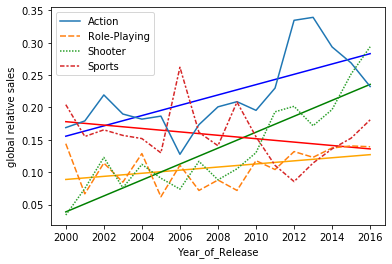

In [178]:
genres = ['Action','Role-Playing','Shooter','Sports']
col = ['blue', 'orange', 'green', 'red']

# contains the year of release as x-values
x = np.array(genre_rel.index.to_list())-2000
# contains the sales figures as y-values
y = np.empty((len(genres), len(x)))
for i,gen in enumerate(genres):
    y[i] = genre_rel[gen].to_list()
    

# Determine the parameters and output the results    
plt.figure()

for i,gen in enumerate(genres):
    
    # Initialize theta0
    theta0 = np.zeros(2)

    # Determine parameters using Gradient descent
    theta_final, loss_history, theta_history = gradient_descent(theta0,x,y[i],lin_fun,1e-2, 1e-6)
    print(theta_final, loss_history[-1:])
    
#     fig,ax = plt.subplots(num=2)

#     ax.set_ylabel('l(Theta)')
#     ax.set_xlabel('Iterations')
#     _=ax.plot(range(len(loss_history))[1:],loss_history[1:],'b.')
#     plt.show()
    
    plt.plot(x+2000, lin_fun(theta_final, x), color=col[i])

sns.lineplot(data=genre_rel)
plt.ylabel('global relative sales')
plt.show()

2nd degree Polynomial regression:

[ 0.1000137   0.0190919  -0.00048854] [0.001194636928802511]
[ 0.04197511  0.00998971 -0.00026814] [0.0005936188399959731]
[0.00863244 0.01339268 0.00013196] [0.000634198481218526]
[ 0.11108986  0.01304699 -0.00077352] [0.0010890423097396024]


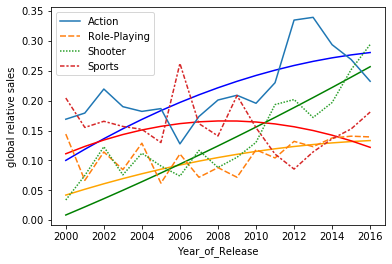

In [187]:
# Determine the parameters and output the results   
plt.figure()

for i,gen in enumerate(genres):
    
    # Initialize theta0
    theta0 = np.zeros(3)

    # Determine parameters using Gradient descent
    theta_final, loss_history, theta_history = gradient_descent(theta0,x,y[i],poly2_fun,1e-4, 1e-6)
    print(theta_final, loss_history[-1:])
    
#     fig,ax = plt.subplots(num=2)

#     ax.set_ylabel('l(Theta)')
#     ax.set_xlabel('Iterations')
#     _=ax.plot(range(len(loss_history))[1:],loss_history[1:],'b.')
#     plt.show()
    
    plt.plot(x+2000, poly2_fun(theta_final, x), color=col[i])

sns.lineplot(data=genre_rel)
plt.ylabel('global relative sales')
plt.show()

3rd degree Polynomial regression: Doesn't work...

In [194]:
# # Determine the parameters and output the results   
# plt.figure()

# for i,gen in enumerate(genres):
    
#     # Initialize theta0
#     theta0 = np.zeros(4)

#     # Determine parameters using Gradient descent
#     theta_final, loss_history, theta_history = gradient_descent(theta0,x,y[i],poly3_fun,1e-2, 1e-6)
#     print(theta_final, loss_history[-1:])
    
# #     fig,ax = plt.subplots(num=2)

# #     ax.set_ylabel('l(Theta)')
# #     ax.set_xlabel('Iterations')
# #     _=ax.plot(range(len(loss_history))[1:],loss_history[1:],'b.')
# #     plt.show()
    
#     plt.plot(x+2000, poly3_fun(theta_final, x), color=col[i])

# sns.lineplot(data=genre_rel)
# plt.ylabel('global relative sales')
# plt.show()